In [2]:
import os
import nltk
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import wordnet, stopwords
import re

In [3]:
# Ensure necessary packages are downloaded
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
# 1. Load Dataset
# Assuming dataset is downloaded and structured
DATA_DIR = "./data"  # Replace with actual dataset path

# Helper function to load data (focus only on train-set5.txt)
def load_data(data_dir):
    train_file = "train_set5.txt"
    test_file = "test_set.txt"

    with open(os.path.join(data_dir, train_file), "r") as f:
        train_data = f.readlines()

    with open(os.path.join(data_dir, test_file), "r") as f:
        test_data = f.readlines()

    return train_data, test_data



In [5]:
# Test load_data
train_data, test_data = load_data(DATA_DIR)
print("Loaded Train Data (Sample):", train_data[:3])
print("Loaded Test Data (Sample):", test_data[:3])


Loaded Train Data (Sample): ['DESC:manner How did serfdom develop in and then leave Russia ?\n', 'ENTY:cremat What films featured the character Popeye Doyle ?\n', "DESC:manner How can I find a list of celebrities ' real names ?\n"]
Loaded Test Data (Sample): ['NUM:dist How far is it from Denver to Aspen ?\n', 'LOC:city What county is Modesto , California in ?\n', 'HUM:desc Who was Galileo ?\n']


In [7]:
# Extract questions and labels
def preprocess_data(data):
    questions, labels = [], []
    for line in data:
        parts = line.strip().split(" ", 1)
        if len(parts) == 2:
            labels.append(parts[0])
            questions.append(parts[1])
    return questions, labels

# Test preprocess_data
train_questions, train_labels = preprocess_data(train_data)
test_questions, test_labels = preprocess_data(test_data)
print("Train Questions (Sample):", train_questions[:3])
print("Train Labels (Sample):", train_labels[:3])
print("Test Questions (Sample):", test_questions[:3])
print("Test Labels (Sample):", test_labels[:3])

Train Questions (Sample): ['How did serfdom develop in and then leave Russia ?', 'What films featured the character Popeye Doyle ?', "How can I find a list of celebrities ' real names ?"]
Train Labels (Sample): ['DESC:manner', 'ENTY:cremat', 'DESC:manner']
Test Questions (Sample): ['How far is it from Denver to Aspen ?', 'What county is Modesto , California in ?', 'Who was Galileo ?']
Test Labels (Sample): ['NUM:dist', 'LOC:city', 'HUM:desc']


In [8]:
# Text Preprocessing
def preprocess_text(questions):
    stop_words = set(stopwords.words('english'))
    processed_questions = []

    for question in questions:
        # Lowercase
        question = question.lower()
        # Remove special characters and numbers
        question = re.sub(r'[^a-zA-Z\s]', '', question)
        # Tokenize
        tokens = nltk.word_tokenize(question)
        # Remove stopwords and apply lemmatization
        lemmatizer = nltk.WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
        processed_questions.append(" ".join(tokens))

    return processed_questions

# Test preprocess_text
train_questions = preprocess_text(train_questions)
test_questions = preprocess_text(test_questions)
print("Processed Train Questions (Sample):", train_questions[:3])
print("Processed Test Questions (Sample):", test_questions[:3])

Processed Train Questions (Sample): ['serfdom develop leave russia', 'film featured character popeye doyle', 'find list celebrity real name']
Processed Test Questions (Sample): ['far denver aspen', 'county modesto california', 'galileo']


In [9]:
# Label Splitting
def split_labels(labels):
    categories, specific_types = [], []
    for label in labels:
        if ":" in label:
            category, specific_type = label.split(":", 1)
        else:
            category, specific_type = label, "generic"
        categories.append(category)
        specific_types.append(specific_type)
    return categories, specific_types

# Test split_labels
train_categories, train_specific_types = split_labels(train_labels)
test_categories, test_specific_types = split_labels(test_labels)
print("Train Categories (Sample):", train_categories[:3])
print("Train Specific Types (Sample):", train_specific_types[:3])
print("Test Categories (Sample):", test_categories[:3])
print("Test Specific Types (Sample):", test_specific_types[:3])


Train Categories (Sample): ['DESC', 'ENTY', 'DESC']
Train Specific Types (Sample): ['manner', 'cremat', 'manner']
Test Categories (Sample): ['NUM', 'LOC', 'HUM']
Test Specific Types (Sample): ['dist', 'city', 'desc']


In [16]:
# Encoding Labels
label_encoder_category = LabelEncoder()
label_encoder_specific = LabelEncoder()

train_categories_encoded = label_encoder_category.fit_transform(train_categories)
test_categories_encoded = label_encoder_category.transform(test_categories)

train_specific_encoded = label_encoder_specific.fit_transform(train_specific_types)
test_specific_encoded = label_encoder_specific.transform(test_specific_types)

# Combine encoded labels for final classification
train_labels_encoded = list(zip(train_categories_encoded, train_specific_encoded))
test_labels_encoded = list(zip(test_categories_encoded, test_specific_encoded))

# Test encoding
print("Encoded Train Labels (Sample):", train_labels_encoded[:3])
print("Encoded Test Labels (Sample):", test_labels_encoded[:3])


Encoded Train Labels (Sample): [(1, 23), (2, 8), (1, 23)]
Encoded Test Labels (Sample): [(5, 14), (4, 3), (3, 12)]


In [ ]:
# Use the same label encoder for both train and test datasets
label_encoder_category = LabelEncoder()
label_encoder_specific = LabelEncoder()

# Fit the encoder on the training data only
train_categories_encoded = label_encoder_category.fit_transform(train_categories)
test_categories_encoded = label_encoder_category.transform(test_categories)  # Use transform to ensure consistency

train_specific_encoded = label_encoder_specific.fit_transform(train_specific_types)
test_specific_encoded = label_encoder_specific.transform(test_specific_types)  # Use transform here too

# Combine encoded labels for final classification
train_labels_encoded = list(zip(train_categories_encoded, train_specific_encoded))
test_labels_encoded = list(zip(test_categories_encoded, test_specific_encoded))

# Ensure that the same encoder is applied to the test set
print("Train Categories Encoded (Sample):", train_categories_encoded[:3])
print("Test Categories Encoded (Sample):", test_categories_encoded[:3])


Train Categories Encoded (Sample): [1 2 1]
Test Categories Encoded (Sample): [5 4 3]


In [18]:
print("Unique Labels in Training Data:", set(train_categories_encoded))
print("Unique Labels in Test Data:", set(test_categories_encoded))


Unique Labels in Training Data: {0, 1, 2, 3, 4, 5}
Unique Labels in Test Data: {0, 1, 2, 3, 4, 5}


In [19]:
# 2. Feature Extraction
# Bag-of-Words representation
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(train_questions)
X_test_bow = vectorizer.transform(test_questions)

# Test Bag-of-Words
print("BOW Train Feature Shape:", X_train_bow.shape)
print("BOW Test Feature Shape:", X_test_bow.shape)

# WordNet Synsets as Features
def wordnet_features(questions):
    features = []
    for question in questions:
        tokens = nltk.word_tokenize(question)
        synset_features = []
        for token in tokens:
            synsets = wordnet.synsets(token)
            # Use the first lemma name of the first synset if available, else use the token
            synset_features.append(synsets[0].lemma_names()[0] if synsets else token)
        features.append(" ".join(synset_features))
    return features

# Test WordNet Synsets
X_train_synsets = vectorizer.fit_transform(wordnet_features(train_questions))
X_test_synsets = vectorizer.transform(wordnet_features(test_questions))
print("WordNet Synsets Train Feature Shape:", X_train_synsets.shape)
print("WordNet Synsets Test Feature Shape:", X_test_synsets.shape)

BOW Train Feature Shape: (5452, 7459)
BOW Test Feature Shape: (500, 7459)
WordNet Synsets Train Feature Shape: (5452, 6712)
WordNet Synsets Test Feature Shape: (500, 6712)


In [20]:
# Combine Features (Bag-of-Words + Synsets)
X_train_combined = np.hstack([X_train_bow.toarray(), X_train_synsets.toarray()])
X_test_combined = np.hstack([X_test_bow.toarray(), X_test_synsets.toarray()])

# Test combined features
print("Combined Train Feature Shape:", X_train_combined.shape)
print("Combined Test Feature Shape:", X_test_combined.shape)


Combined Train Feature Shape: (5452, 14171)
Combined Test Feature Shape: (500, 14171)


In [21]:
# Fix 1 (Combine labels into single label)
flat_label_encoder = LabelEncoder()
flat_train_labels = flat_label_encoder.fit_transform([f"{cat}_{type}" for cat, type in zip(train_categories, train_specific_types)])
flat_test_labels = flat_label_encoder.transform([f"{cat}_{type}" for cat, type in zip(test_categories, test_specific_types)])

# Train the model using the combined labels
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train_combined, flat_train_labels)



SVC(kernel='linear', probability=True)

Evaluating SVM Model
Accuracy: 0.6920
Precision: 0.7424
Recall: 0.6920
F1 Score: 0.6838
Confusion Matrix:
[[  0   1   0 ...   0   0   0]
 [  0   6   2 ...   0   0   0]
 [  0   0 119 ...   0   0   0]
 ...
 [  0   0   1 ...   4   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.86      0.75      0.80         8
           2       0.68      0.97      0.80       123
           3       0.67      0.57      0.62         7
           4       0.07      0.50      0.12         2
           5       0.20      0.17      0.18         6
           6       0.90      0.56      0.69        16
           7       1.00      0.50      0.67         2
           8       1.00      0.90      0.95        10
           9       0.00      0.00      0.00         0
          10       1.00      0.50      0.67         6
          11       0.50      0

c:\Users\MSI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MSI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MSI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MSI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetr

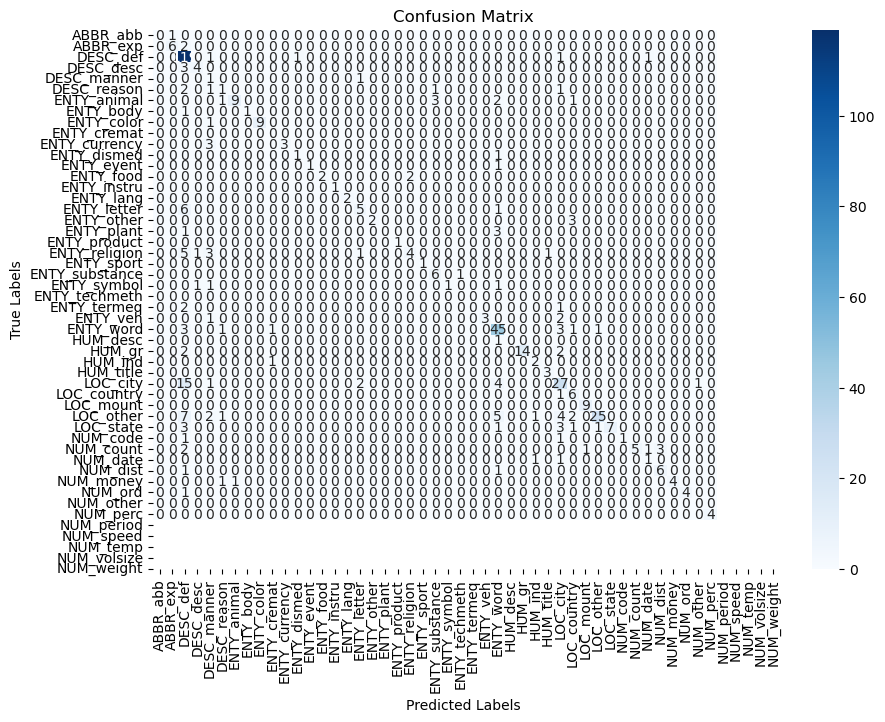

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.86      0.75      0.80         8
           2       0.68      0.97      0.80       123
           3       0.67      0.57      0.62         7
           4       0.07      0.50      0.12         2
           5       0.20      0.17      0.18         6
           6       0.90      0.56      0.69        16
           7       1.00      0.50      0.67         2
           8       1.00      0.90      0.95        10
           9       0.00      0.00      0.00         0
          10       1.00      0.50      0.67         6
          11       0.50      0.50      0.50         2
          12       1.00      0.50      0.67         2
          13       1.00      0.50      0.67         4
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         2
          17       0.56      0.42      0.48        12
    

c:\Users\MSI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MSI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MSI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MSI\anaconda3\lib\site-packages\sklearn\metrics\_classificat

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Extended evaluation function
def evaluate_model(model, X_test, y_test):
    # Make predictions
    y_pred = model.predict(X_test)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Precision, Recall, F1 Score
    precision = precision_score(y_test, y_pred, average='weighted')  # 'weighted' for multi-class
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

        # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=flat_label_encoder.classes_, yticklabels=flat_label_encoder.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

# Example usage with your model:
print("Evaluating SVM Model")
evaluate_model(svm_model, X_test_combined, flat_test_labels)  # Replace flat_test_labels with your encoded test labels


In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel type
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'degree': [3, 4, 5],  # Degree for polynomial kernel
    'coef0': [0, 1],  # Independent term in kernel function
}

# Initialize the SVM model
svm_model = SVC(probability=True)

# Apply GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_combined, flat_train_labels)

# Get the best hyperparameters
print("Best hyperparameters found: ", grid_search.best_params_)

# Use the best model
best_svm_model = grid_search.best_estimator_

# Evaluation function with all requested metrics
def evaluate_model(model, X_test, y_test):
    # Make predictions
    y_pred = model.predict(X_test)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Precision, Recall, F1 Score
    precision = precision_score(y_test, y_pred, average='weighted')  # 'weighted' for multi-class
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

# Evaluate the best model from GridSearchCV
print("Evaluating Best SVM Model from GridSearchCV")
evaluate_model(best_svm_model, X_test_combined, flat_test_labels)


Fitting 5 folds for each of 144 candidates, totalling 720 fits


c:\Users\MSI\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


KeyboardInterrupt: 